# Demo - Conditional Gaussianization Flow (Regression)

In [1]:
# @title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os

    os.system("pip install objax chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
# jax packages
import jax
import jax.numpy as jnp
from jax.config import config

# import chex
config.update("jax_enable_x64", False)

import objax
import chex
import numpy as np
from functools import partial

# library functions
from rbig_jax.transforms.parametric.mixture.logistic import InitMixtureLogisticCDF
from rbig_jax.transforms.parametric.mixture.gaussian import InitMixtureGaussianCDF
from rbig_jax.transforms.logit import InitLogitTransform
from rbig_jax.transforms.inversecdf import InitInverseGaussCDF
from rbig_jax.transforms.parametric.householder import InitHouseHolder
from distrax._src.bijectors.sigmoid import Sigmoid
from distrax._src.bijectors.inverse import Inverse


KEY = jax.random.PRNGKey(seed=123)

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import corner
from IPython.display import HTML

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%load_ext lab_black
%matplotlib inline
%load_ext autoreload
%autoreload 2

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Demo Data

In [24]:
import tensorflow_datasets as tfds
import tensorflow as tf
from sklearn import datasets
import tensorflow_datasets as tfds
from typing import Iterator, Mapping
import numpy as np

Batch = Mapping[str, np.ndarray]


def load_dataset(
    n_train: int,
    batch_size: int,
    seed: int,
    n_samples: int = 2_000,
    n_features: int = 2,
    noise: float = 0.05,
) -> Iterator[Batch]:
    # make random normally distributed data
    rng = np.random.RandomState(seed)
    X0 = rng.rand(n_samples, 1)
    X1 = rng.randn(n_samples, 1)
    X = np.concatenate([X0, X1], axis=1)
    y = np.sin(5 * X[:, 0]) + X[:, 1] ** 2
    #     X, y = datasets.make_regression(
    #         n_samples=n_samples, n_features=n_features, noise=noise, random_state=seed,
    #     )
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    ds = ds.shuffle(buffer_size=10 * batch_size)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=5)
    ds = ds.repeat()
    return iter(tfds.as_numpy(ds))

In [25]:
# train/valid dataset loaders
# wandb_logger.config.batch_size = 128
n_init_samples = 5_000
n_train = 5_000

init_ds = load_dataset(n_init_samples, n_init_samples, 123)

# demo batch
init_X, init_Y = next(init_ds)

In [26]:
init_Y.shape, init_X.shape

((2000,), (2000, 2))

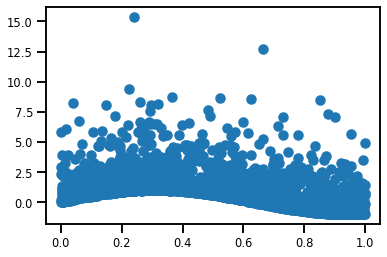

In [27]:
fig, ax = plt.subplots()

ax.scatter(init_X[:, 0], init_Y)
plt.show()

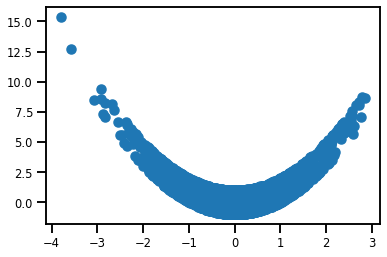

In [28]:
fig, ax = plt.subplots()

ax.scatter(init_X[:, 1], init_Y)
plt.show()

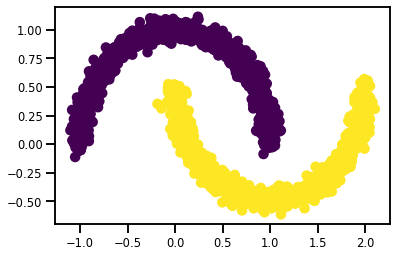

In [6]:
fig, ax = plt.subplots()

ax.scatter(init_X[:, 0], init_X[:, 1], c=init_Y)
plt.show()

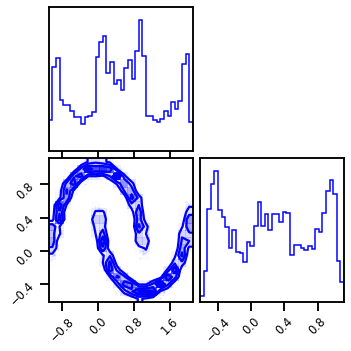

In [7]:
# plot data
fig = corner.corner(init_X, color="blue", hist_bin_factor=2)

## DataLoader

In [8]:
from typing import Optional
from chex import Array
from einops import rearrange

PRNGKey = Array


def prepare_data(batch: Batch) -> Array:
    inputs, labels = batch

    # select image from tfds
    inputs = inputs.astype(jnp.float32)
    labels = labels.astype(jnp.float32)

    # make 1D
    labels = jnp.expand_dims(labels, axis=-1)

    return inputs, labels

## Model

In [9]:
from rbig_jax.models.gaussflow import init_default_gf_model

# initialization data
n_init_samples = 10_000

init_ds = load_dataset(n_init_samples, n_init_samples, 123)
# demo batch
init_ds = next(init_ds)
X_init, Y_init = prepare_data(init_ds)
X_init, Y_init = np.array(X_init), np.array(Y_init)


# marginal uniformization
mixture = "gaussian"
n_components = 10
init_mixcdf = "gmm"

# inverse cdf
inverse_cdf = "gaussian"

# rotation transformation
n_reflections = 4
init_rotation = "random"

# nn params
n_blocks = 6

In [10]:
# init model
gf_model = init_default_gf_model(
    shape=X_init.shape[1:],
    X=X_init,
    n_blocks=n_blocks,
    mixture=mixture,
    n_components=n_components,
    init_mixcdf=init_mixcdf,
    inverse_cdf=inverse_cdf,
    init_rotation=init_rotation,
    n_reflections=n_reflections,
)

Initializing - Block: 6 | Layer 17: 100%|██████████| 6/6 [00:04<00:00,  1.44it/s]


### Plot Initial Layers

In [11]:
%%time

# X_g = gf_model.forward(X_init)
# X_g, X_ldj = gf_model.forward_and_log_det(X_init)

gf_model.score(X_init)

CPU times: user 1.03 s, sys: 76.9 ms, total: 1.11 s
Wall time: 944 ms


DeviceArray(0.7585135, dtype=float32)

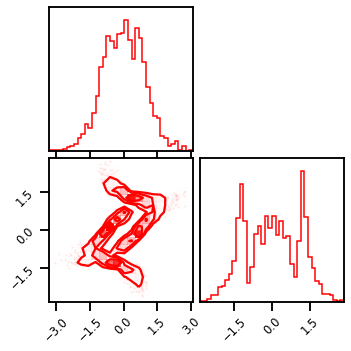

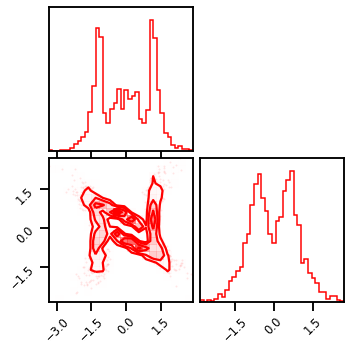

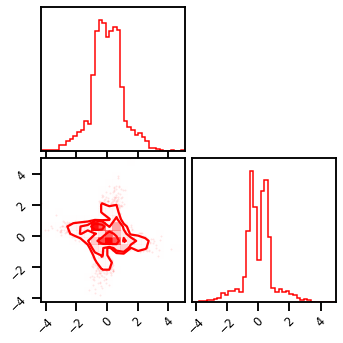

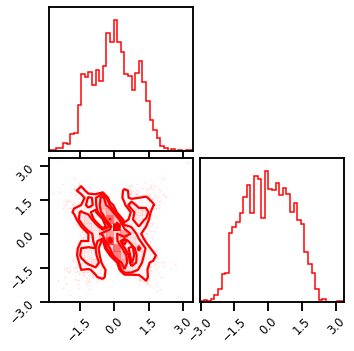

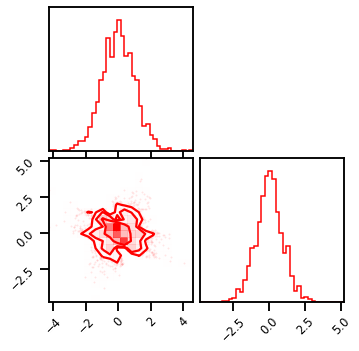

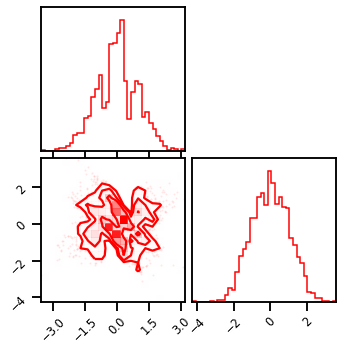

In [12]:
X_g = X_init.copy()

for ibijector in gf_model.bijectors:

    X_g = ibijector.forward(X_g)

    if ibijector.name == "HouseHolder":
        fig = corner.corner(np.array(X_g), color="red", hist_bin_factor=2)

### Conditional Model

In [13]:
from flax import struct
from typing import Callable, Tuple
from chex import Array


@struct.dataclass
class ConditionalModel:
    params: dict
    model: Callable = struct.field(pytree_node=False)

    def forward(self, inputs) -> Tuple[Array, Array]:
        # forward pass for params
        outputs = self.model.apply(self.params, inputs)
        # split params
        split = outputs.shape[1] // 2

        # compute means and log stds
        means = outputs[..., :split]
        log_stds = outputs[..., split:]

        return means, log_stds

In [14]:
import flax
from flax import linen as nn

# create model
model = nn.Dense(features=4)
# create dummy variable
rng, model_rng = jax.random.split(KEY, 2)
params = model.init(model_rng, Y_init)

# initialize conditional model
cond_model = ConditionalModel(params=params, model=model)

# forward pass
means, log_stds = cond_model.forward(Y_init)
means.shape, log_stds.shape

((2000, 2), (2000, 2))

In [87]:
# from rbig_jax.transforms.base import Bijector, BijectorChain
from typing import Iterable
from chex import dataclass
from distrax._src.distributions.distribution import Distribution
import abc


@struct.dataclass
class Bijector:
    def forward(self, inputs: Array) -> Array:
        """Computes y = f(x)."""
        outputs, _ = self.forward_and_log_det(inputs)
        return outputs

    def inverse(self, inputs: Array) -> Array:
        """Computes x = f^{-1}(y)."""
        outputs, _ = self.inverse_and_log_det(inputs)
        return outputs

    def forward_log_det_jacobian(self, inputs: Array) -> Array:
        """Computes log|det J(f)(x)|."""
        _, logdet = self.forward_and_log_det(inputs)
        return logdet

    def inverse_log_det_jacobian(self, inputs: Array) -> Array:
        """Computes log|det J(f^{-1})(y)|."""
        _, logdet = self.inverse_and_log_det(inputs)
        return logdet

    @abc.abstractmethod
    def forward_and_log_det(self, inputs: Array) -> Tuple[Array, Array]:
        """Computes y = f(x) and log|det J(f)(x)|."""

    def inverse_and_log_det(self, inputs: Array) -> Tuple[Array, Array]:
        """Computes x = f^{-1}(y) and log|det J(f^{-1})(y)|."""
        raise NotImplementedError(
            f"Bijector {self.name} does not implement `inverse_and_log_det`."
        )

    @property
    def name(self) -> str:
        """Name of the bijector."""
        return self.__class__.__name__


@struct.dataclass
class BijectorChain:
    bijectors: Iterable[Bijector]

    def forward_and_log_det(self, inputs: Array) -> Tuple[Array, Array]:

        outputs = inputs
        total_logabsdet = jnp.zeros_like(outputs)
        # total_logabsdet = jnp.zeros((outputs.shape[0],))
        # total_logabsdet = jnp.expand_dims(total_logabsdet, axis=1)
        for ibijector in self.bijectors:
            outputs, logabsdet = ibijector.forward_and_log_det(outputs)
            total_logabsdet += logabsdet  # sum_last(logabsdet, ndims=logabsdet.ndim)

        return outputs, total_logabsdet

    def inverse_and_log_det(self, inputs: Array) -> Tuple[Array, Array]:

        outputs = inputs
        total_logabsdet = jnp.zeros_like(outputs)
        # total_logabsdet = jnp.expand_dims(total_logabsdet, axis=1)
        for ibijector in reversed(self.bijectors):
            outputs, logabsdet = ibijector.inverse_and_log_det(outputs)
            total_logabsdet += logabsdet  # sum_last(logabsdet, ndims=logabsdet.ndim)

        return outputs, total_logabsdet

    def forward(self, inputs: Array) -> Array:

        outputs = inputs
        for ibijector in self.bijectors:
            outputs = ibijector.forward(outputs)

        return outputs

    def inverse(self, inputs: Array) -> Array:

        outputs = inputs
        for ibijector in reversed(self.bijectors):
            outputs = ibijector.inverse(outputs)

        return outputs

    def forward_log_det_jacobian(self, inputs: Array) -> Array:

        outputs = inputs
        total_logabsdet = jnp.zeros_like(outputs)
        for ibijector in self.bijectors:
            outputs, logabsdet = ibijector.forward_and_log_det(outputs)
            total_logabsdet += logabsdet

        return total_logabsdet

    def inverse_log_det_jacobian(self, inputs: Array) -> Tuple[Array, Array]:

        outputs = inputs
        total_logabsdet = jnp.zeros_like(outputs)
        # total_logabsdet = jnp.expand_dims(total_logabsdet, axis=1)
        for ibijector in reversed(self.bijectors):
            outputs, logabsdet = ibijector.inverse_and_log_det(outputs)
            total_logabsdet += logabsdet  # sum_last(logabsdet, ndims=logabsdet.ndim)

        return total_logabsdet


@struct.dataclass
class ConditionalGaussianizationFlow(BijectorChain):
    bijectors: Iterable[Bijector]
    base_dist: Distribution = struct.field(pytree_node=False)
    encoder: Callable

    def score_samples(self, inputs, outputs):

        # forward propagation
        z, log_det = self.forward_and_log_det(inputs)

        # encode params
        latent_mean, latent_log_stds = self.encoder.forward(outputs)

        # conditional base distribution
        dist = self.base_dist(loc=latent_mean, scale=jnp.exp(latent_log_stds))

        # calculate latent probability
        latent_prob = dist.log_prob(z)
        # calculate log probability
        log_prob = latent_prob.sum(axis=1) + log_det.sum(axis=1)

        return log_prob

    def score(self, inputs, outputs):
        return -jnp.mean(self.score_samples(inputs, outputs))

    def sample(self, seed: int, n_samples: int):
        raise NotImplementedError()


#         # generate Gaussian samples
#         X_g_samples = self.base_dist.sample(seed=seed, sample_shape=n_samples)
#         # # inverse transformation
#         return self.inverse(X_g_samples)

In [88]:
from distrax._src.distributions.normal import Normal

cgf_model = ConditionalGaussianizationFlow(
    bijectors=gf_model.bijectors, base_dist=Normal, encoder=cond_model
)

#### Training

In [89]:
from chex import dataclass


def loss_fn(model: dataclass, batch: Batch) -> Array:

    inputs, outputs = prepare_data(batch)

    # negative log likelihood loss
    nll_loss = model.score(inputs=inputs, outputs=outputs)

    return nll_loss


@jax.jit
def eval_fn(model: dataclass, batch: Batch) -> Array:

    inputs, outputs = prepare_data(batch)

    # negative log likelihood loss
    nll_loss = model.score(inputs=inputs, outputs=outputs)

    return nll_loss

In [90]:
init_ds = load_dataset(n_init_samples, n_init_samples, 123)

nll_loss = loss_fn(cgf_model, next(init_ds))
print(f"Initial NLL Loss (Train): {nll_loss:.4f}")


nll_loss = eval_fn(cgf_model, next(init_ds))
print(f"Initial NLL Loss (Train): {nll_loss:.4f}")

Initial NLL Loss (Train): 20.5310
Initial NLL Loss (Train): 20.5310


### Optimizer

In [91]:
import optax

# optimizer params
epochs = 5_000  # 12_000
eval_frequency = 50
learning_rate = 1e-4

# intialize optimizer
# optimizer = optax.adam(learning_rate=learning_rate)
optimizer = optax.chain(
    #     optax.clip_by_global_norm(0.25),
    optax.clip(1.0),
    optax.adam(learning_rate, b1=0.9, b2=0.99, eps=1e-5),
)

# intialize optimizer state
opt_state = optimizer.init(cgf_model)

### Train Step

In [92]:
from typing import Tuple, Any

OptState = Any


@jax.jit
def update(
    params: dataclass, opt_state: OptState, batch: Batch
) -> Tuple[dataclass, OptState]:
    """Single SGD update step."""
    # calculate the loss AND the gradients
    loss, grads = jax.value_and_grad(loss_fn)(params, batch)

    # update the gradients
    updates, new_opt_state = optimizer.update(grads, opt_state)

    # update the parameters
    new_params = optax.apply_updates(params, updates)

    # return loss AND new opt_state
    return new_params, new_opt_state, loss

### Train Loop

In [93]:
train_ds = load_dataset(n_train, 128, 123)
valid_ds = load_dataset(2_000, 128, 123 + 100)


metrics = {
    "train_step": list(),
    "train_loss": list(),
    "valid_step": list(),
    "valid_loss": list(),
}


eval_loss = 0.0

In [94]:
# %%wandb

import tqdm


with tqdm.trange(epochs) as pbar:
    for step in pbar:
        cgf_model, opt_state, loss = update(cgf_model, opt_state, next(train_ds))

        pbar.set_description(f"Train Loss: {loss:.4f} | Valid Loss: {eval_loss:.4f}")
        #         wandb.log({"train_loss": float(loss), "training_step": step})
        metrics["train_step"].append(step)
        metrics["train_loss"].append(loss)

        if step % eval_frequency == 0:
            eval_loss = eval_fn(cgf_model, next(valid_ds))

            pbar.set_description(
                f"Train Loss: {loss:.4f} | Valid Loss: {eval_loss:.4f}"
            )
            #             wandb.log({"validation_loss": float(eval_loss), "training_step": step})
            metrics["valid_step"].append(step)
            metrics["valid_loss"].append(eval_loss)

Train Loss: 0.1759 | Valid Loss: 0.1587: 100%|██████████| 5000/5000 [00:53<00:00, 94.31it/s]  


### Results

#### Losses

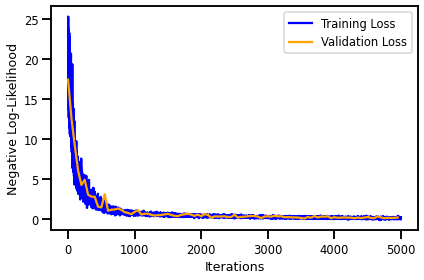

In [95]:
fig, ax = plt.subplots()
ax.plot(
    metrics["train_step"], metrics["train_loss"], label="Training Loss", color="blue"
)
ax.plot(
    metrics["valid_step"],
    metrics["valid_loss"],
    label="Validation Loss",
    color="orange",
)
ax.set(
    xlabel="Iterations", ylabel="Negative Log-Likelihood",
)
plt.legend()
plt.tight_layout()
plt.show()

#### Inverse Transform

### Log Probability

#### Plot: Original Density

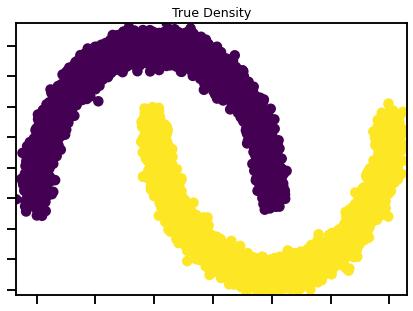

In [96]:
from matplotlib import cm

cmap = cm.magma
# Original Density
n_samples = 10_000
noise = 0.05
seed = 42
X_plot, y_plot = datasets.make_moons(
    n_samples=n_samples, noise=noise, random_state=seed
)


fig, ax = plt.subplots(figsize=(7, 5))
h = ax.scatter(
    X_plot[:, 0],
    X_plot[:, 1],
    c=y_plot,  # bins=512, density=True,  # vmin=0.0, vmax=1.0
)
ax.set_title("True Density")
ax.set(
    xlim=[X_plot[:, 0].min(), X_plot[:, 0].max()],
    ylim=[X_plot[:, 1].min(), X_plot[:, 1].max()],
    xticklabels="",
    yticklabels="",
)
plt.show()

In [97]:
%%time

n_grid = 500
buffer = 0.01
xline = jnp.linspace(X_init[:, 0].min() - buffer, X_init[:, 0].max() + buffer, n_grid)
yline = jnp.linspace(X_init[:, 1].min() - buffer, X_init[:, 1].max() + buffer, n_grid)
xgrid, ygrid = jnp.meshgrid(xline, yline)
xyinput = jnp.concatenate([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], axis=1)

# general grid points
# xyinput = generate_2d_grid(X_init, 500, buffer=0.2)


# calculate log probability
X_log_prob_z1 = cgf_model.score_samples(xyinput, jnp.zeros(xyinput.shape[0])[:, None])
X_log_prob_z2 = cgf_model.score_samples(xyinput, jnp.ones(xyinput.shape[0])[:, None])

CPU times: user 6.58 s, sys: 1.84 s, total: 8.43 s
Wall time: 2.73 s


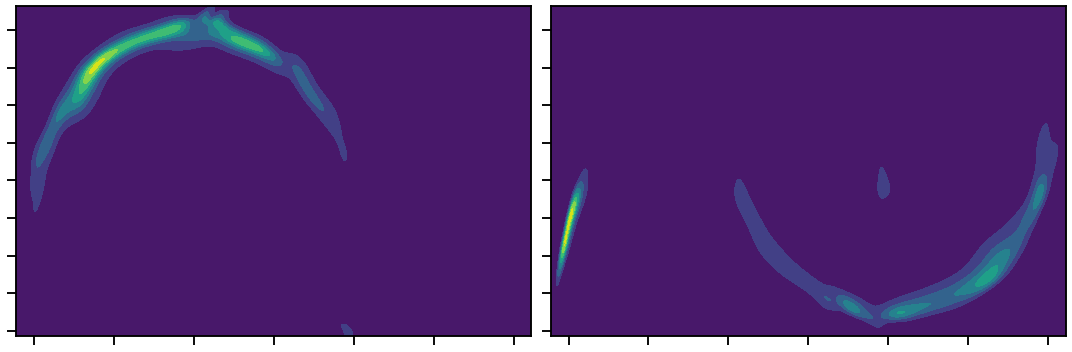

In [98]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

ax[0].contourf(xgrid, ygrid, np.exp(X_log_prob_z1).reshape(n_grid, n_grid))
ax[1].contourf(xgrid, ygrid, np.exp(X_log_prob_z2).reshape(n_grid, n_grid))
ax[1].set(
    xlim=[xyinput[:, 0].min(), xyinput[:, 0].max()],
    ylim=[xyinput[:, 1].min(), xyinput[:, 1].max()],
    xticklabels="",
    yticklabels="",
)
ax[0].set(
    xlim=[xyinput[:, 0].min(), xyinput[:, 0].max()],
    ylim=[xyinput[:, 1].min(), xyinput[:, 1].max()],
    xticklabels="",
    yticklabels="",
)
plt.tight_layout()
plt.show()

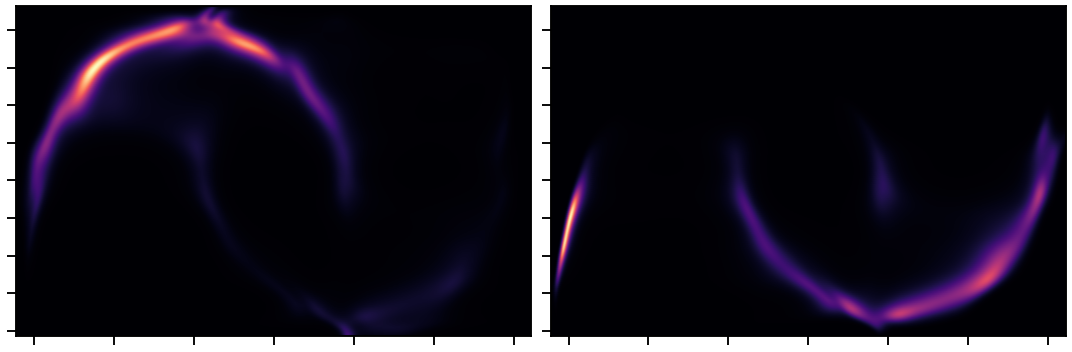

In [99]:
# # Original Density
# n_samples = 1_000_000
# ds_plot = PlaneDataset(n_samples=n_samples, noise=noise, seed=seed)
# X_plot = ds_plot[:]

# Estimated Density
cmap = cm.magma  # "Reds"
# probs = jnp.exp(X_log_prob)
# probs = np.clip(probs, 0.0, 1.0)
# probs = np.clip(probs, None, 0.0)


cmap = cm.magma  # "Reds"

fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

h1 = ax[0].scatter(
    xyinput[:, 0],
    xyinput[:, 1],
    s=1,
    c=np.exp(X_log_prob_z1),
    cmap=cmap,
    #     vmax=0.01,  # vmin=0.0, vmax=1.0
)
h1 = ax[1].scatter(
    xyinput[:, 0],
    xyinput[:, 1],
    s=1,
    c=np.exp(X_log_prob_z2),
    cmap=cmap,
    #     vmax=0.01,  # vmin=0.0, vmax=1.0
)
ax[0].set(
    xlim=[xyinput[:, 0].min(), xyinput[:, 0].max()],
    ylim=[xyinput[:, 1].min(), xyinput[:, 1].max()],
    xticklabels="",
    yticklabels="",
)
ax[1].set(
    xlim=[xyinput[:, 0].min(), xyinput[:, 0].max()],
    ylim=[xyinput[:, 1].min(), xyinput[:, 1].max()],
    xticklabels="",
    yticklabels="",
)


plt.tight_layout()
plt.show()

### Sampling

In [25]:
# %%time
# n_gen_samples = 100_000
# pred_batch_size = 10_000
# X_samples = []
# for _ in tqdm.trange(n_gen_samples // pred_batch_size):

#     X_samples.append(final_bijector.sample(seed=123, n_samples=pred_batch_size))

In [29]:
%%time

n_gen_samples = 100_000

X_samples = gf_model.sample(seed=123, n_samples=n_gen_samples)

CPU times: user 6min 51s, sys: 3.86 s, total: 6min 55s
Wall time: 1min 4s


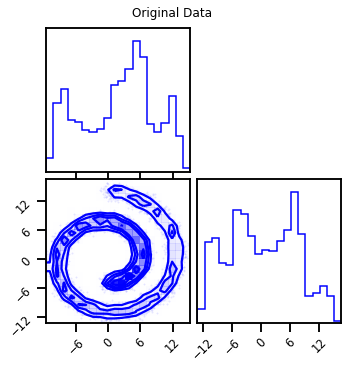

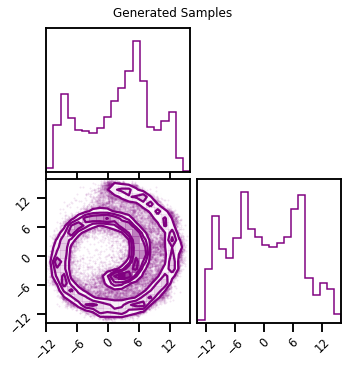

In [30]:
fig = corner.corner(np.array(X_init), color="blue", label="Original Data")
fig.suptitle("Original Data")
plt.show()

fig2 = corner.corner(np.array(X_samples), color="purple")
fig2.suptitle("Generated Samples")
plt.show()

## Each Layer

#### Trained Model

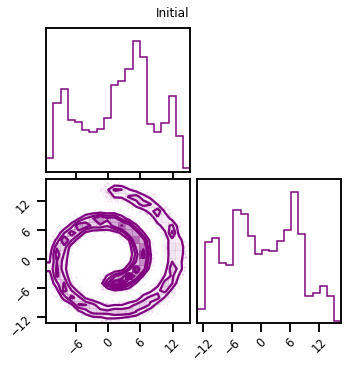

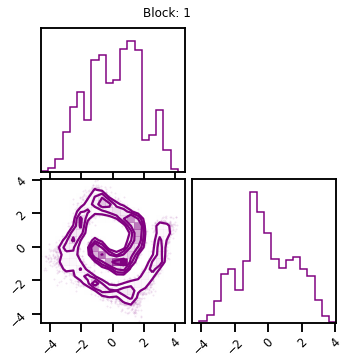

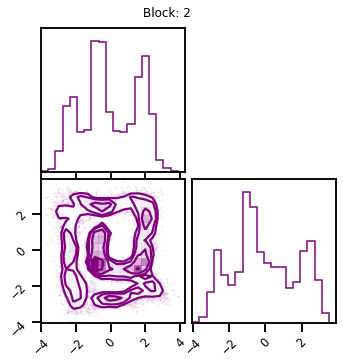

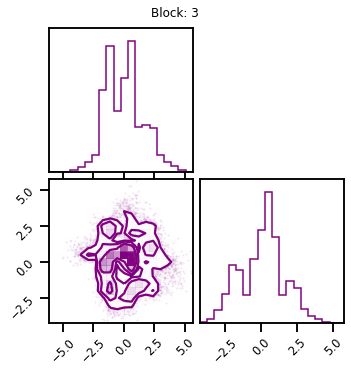

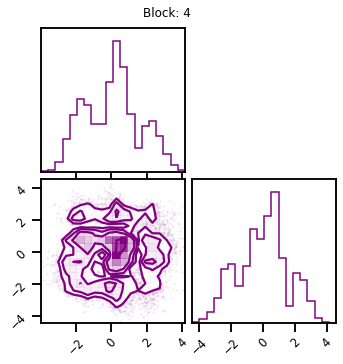

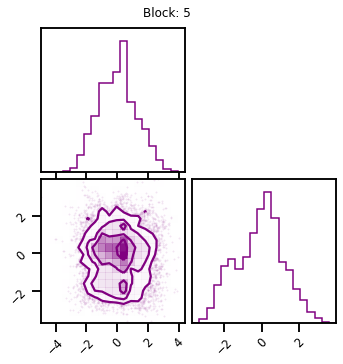

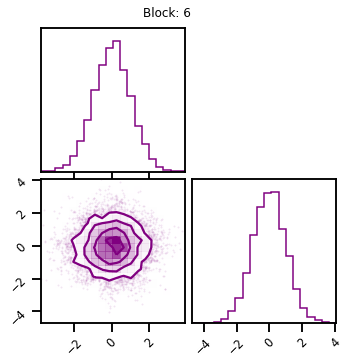

In [31]:
X_g = X_init.copy()

fig = corner.corner(X_g, color="purple")
fig.suptitle("Initial")

plt.show()

for ilayer, ibijector in enumerate(gf_model.bijectors):

    X_g = ibijector.forward(X_g)

    if ibijector.name == "HouseHolder":
        fig = corner.corner(np.array(X_g), color="purple")
        fig.suptitle(f"Block: {(ilayer+1)//3}")
        plt.show()

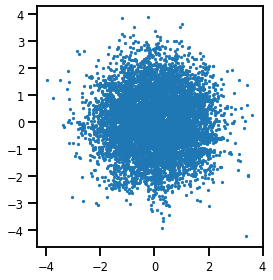

In [140]:
fig, ax = plt.subplots()
ax.scatter(X_g[:, 0], X_g[:, 1], s=3)
ax.set_aspect("equal", "box")
plt.tight_layout()

## Saving/Loading Model

In [226]:
import pickle

#### Save Model

In [227]:
import joblib

joblib.dump(gf_model, "gf_model.pickle")

['gf_model.pickle']

#### Load Model

In [228]:
rbig_model_loaded = joblib.load("gf_model.pickle")